<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/HAR/UCI_HAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import keras

In [2]:
#라벨 정리
ACTIVITIES={
    0:'WALKING',
    1:'WALKING_UPSTAIRS',
    2:'WALKING_DOWNSTAIRS',
    3:'SITTING',
    4:'STANDING',
    5:'LAYING'
}

In [3]:
#혼돈행렬 함수
def confustion_matrix(Y_true, Y_pred):
  Y_true=pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
  Y_pred=pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

  return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [19]:
DATADIR= os.path.join(os.getcwd(), 'drive','MyDrive','datasets')

SIGNALS = ["body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"]

In [26]:
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename= DATADIR + f'/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)

    return np.transpose(signals_data, (1, 2, 0))

In [27]:
def load_y(subset):
    filename= DATADIR + f'/UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = pd.read_csv(filename, delim_whitespace=True, header=None)[0]
    return pd.get_dummies(y).values

In [28]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, y_train, X_test,  y_test

In [29]:
np.random.seed(36)
rn.seed(36)
tf.random.set_seed(36)

In [30]:
#라벨 개수 세기
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [31]:
#전에 정리한 데이터셋 불러오기
X_train, Y_train, X_val, Y_val= load_signals('train'), load_y('train'), load_signals('test'), load_y('test')

/tmp/ipython-input-3567053776.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-3567053776.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-3567053776.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-3567053776.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd

In [35]:
class scaling_tseries_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scale = None

    def fit(self, X):
      #오버랩핑인줄 알았는데 지피티는 아니라고 함....
      #시계열 후반부 절반을 슬라이싱
      #=> 이걸 왜해???: 훈련 데이터와 테스트 데이터의 분포를 유지하기 위해서
      #시계열 데이터에서는 시간이 흐름에 따라 데이터 분포가 바뀌는 경우가 있다.
      #-> 따라서!! 최신 데이터 분포에 맞춰 스케일링을 맞추는 것이 적절할 수 있음
      #모든 시간 구간의 데이터를 스케일 기준으로 삼으면 오버피팅 가능성
        remove = int(X.shape[1] / 2)
        temp_X = X[:, -remove:, :]
        #데이터 flatten
        temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
        scale = StandardScaler()
        scale.fit(temp_X)
        self.scale = scale
        return self

    def transform(self, X):
        temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
        temp_X1 = self.scale.transform(temp_X1)
        return temp_X1.reshape(X.shape)

In [36]:
#데이터 표준화
Scale= scaling_tseries_data()
Scale.fit(X_train)
X_train_sc= Scale.transform(X_train)
X_val_sc= Scale.transform(X_val)

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras.regularizers import L2
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv1D, MaxPooling1D


In [47]:
def base_model():
        model= Sequential()
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=(X_train_sc.shape[1], X_train_sc.shape[2])))
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.6))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dense(6, activation='softmax'))
        model.summary()

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        history= model.fit(X_train_sc, Y_train, epochs=30, batch_size=16,validation_data=(X_val_sc, Y_val), verbose=1)
        return model, history

In [59]:
def regularized_cnn_model():
        model = Sequential()
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',
                        kernel_regularizer=L2(0.1),input_shape=(128,9)))
        model.add(Conv1D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=L2(0.06),kernel_initializer='he_uniform'))
        model.add(Dropout(0.65))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(6, activation='softmax'))
        model.summary()

        adam = Adam(learning_rate=0.001)
        rmsprop = keras.optimizers.RMSprop(learning_rate=0.001)
        def step_decay(epoch):
            return float(0.001 * math.pow(0.6, math.floor((1+epoch)/10)))

        lrate = LearningRateScheduler(step_decay)
        callbacks_list = [lrate]

        model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

        history= model.fit(X_train_sc, Y_train, epochs= 30, batch_size= 16, validation_data= (X_val_sc, Y_val), verbose=1)
        return model, history

In [49]:
#모델 학습
cnn_base_model, history= base_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1984)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        99,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,556 (404.52 KB)

 Trainable params: 103,556 (404.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6956 - loss: 0.8997 - val_accuracy: 0.8697 - val_loss: 0.3352
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9356 - loss: 0.1565 - val_accuracy: 0.8945 - val_loss: 0.2925
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9517 - loss: 0.1126 - val_accuracy: 0.9077 - val_loss: 0.2792
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9588 - loss: 0.0987 - val_accuracy: 0.8951 - val_loss: 0.3213
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9605 - loss: 0.0898 - val_accuracy: 0.9155 - val_loss: 0.2701
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9622 - loss: 0.0888 - val_accuracy: 0.9182 - val_loss: 0.2911
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9640 - loss: 0.0833 - val_accuracy: 0.9125 - val_loss: 0.3573
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9685 - loss: 0.0674 - val_accu

In [60]:
#규제 적용 모델
regularized_cnn_model, history= regularized_cnn_model()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 126, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 124, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 124, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 62, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 992)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │        31,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,422 (134.46 KB)

 Trainable params: 34,422 (134.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6323 - loss: 6.7947 - val_accuracy: 0.8052 - val_loss: 1.5726
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8949 - loss: 0.9677 - val_accuracy: 0.8052 - val_loss: 0.6939
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9164 - loss: 0.4143 - val_accuracy: 0.8042 - val_loss: 0.5938
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9262 - loss: 0.3211 - val_accuracy: 0.8490 - val_loss: 0.4977
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9289 - loss: 0.2912 - val_accuracy: 0.8534 - val_loss: 0.4623
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9342 - loss: 0.2623 - val_accuracy: 0.8724 - val_loss: 0.4473
Epoch 7/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9322 - loss: 0.2545 - val_accuracy: 0.8633 - val_loss: 0.4391
Epoch 8/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9368 - loss: 0.2422 - val_accuracy: 

In [61]:
def confusion_matrix_rnn(Y_true, Y_pred):
    from sklearn import metrics
    ACTIVITIES = {
        0: 'WALKING',
        1: 'WALKING_UPSTAIRS',
        2: 'WALKING_DOWNSTAIRS',
        3: 'SITTING',
        4: 'STANDING',
        5: 'LAYING'}

    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)
cm_result= confusion_matrix_rnn(Y_val, regularized_cnn_model.predict(X_val_sc))
cm_result

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([[510,   0,   0,   0,   0,  27],
       [  0, 362, 101,   2,   0,  26],
       [  0,  79, 445,   1,   0,   7],
       [  0,   0,   0, 489,   6,   1],
       [  0,   0,   0,   7, 400,  13],
       [  0,   0,   0,  41,  24, 406]])

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


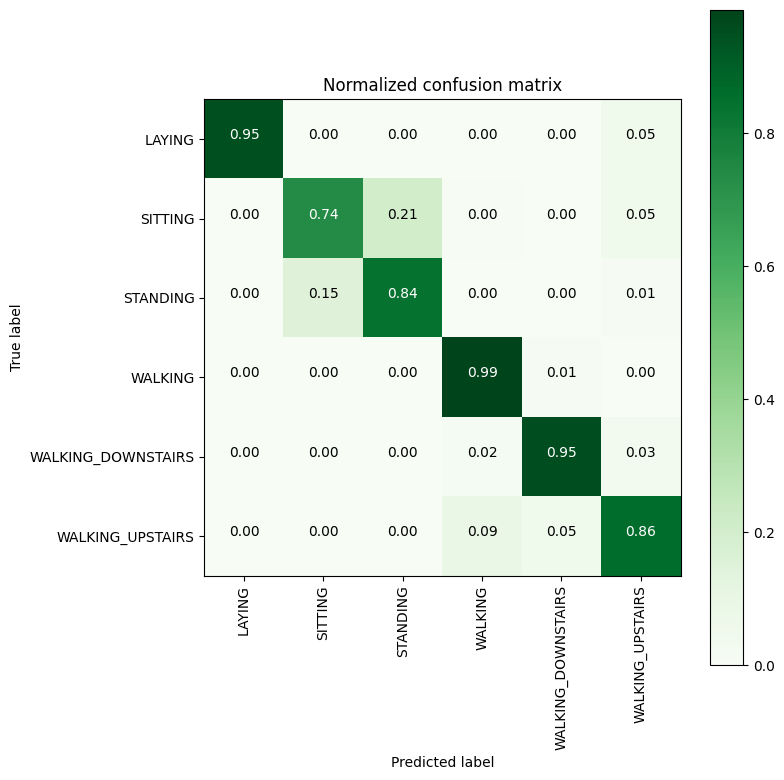

In [62]:
#혼돈행렬 시각화
import matplotlib.pyplot as plt
import itertools

plt.figure(figsize=(8,8))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix_rnn(Y_val, regularized_cnn_model.predict(X_val_sc))
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
plot_confusion_matrix(cm, classes= labels, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

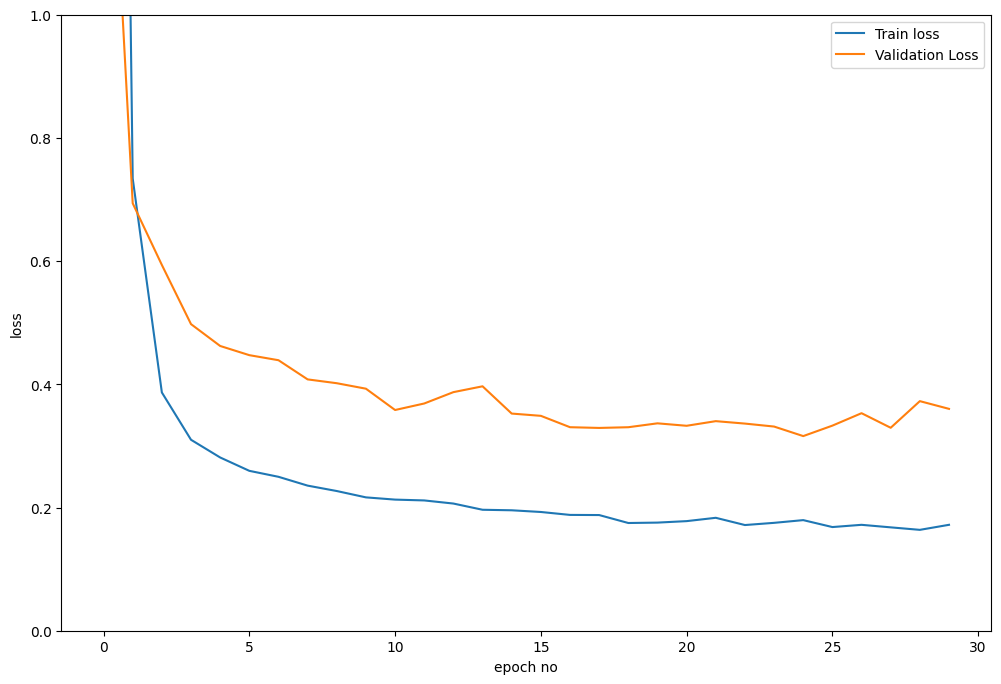

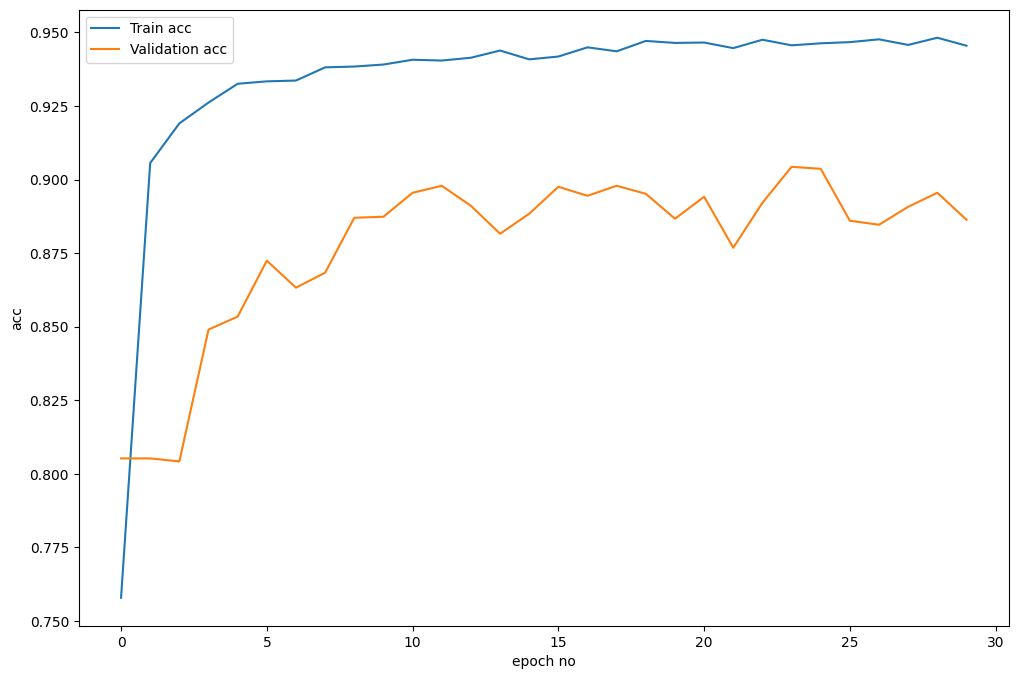

In [63]:
#로스
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.ylim(0,1)
plt.legend()
plt.show()

#정확도
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'],label='Train acc')
plt.plot(history.history['val_accuracy'],label = 'Validation acc')
plt.xlabel('epoch no')
plt.ylabel('acc')
plt.legend()
plt.show()

In [64]:
#??